In [1]:
import pandas as pd 
df = pd.read_csv('/home/germain/Documents/topic models/generalized_topic_model_dev/data/us_congressional_record/us_congress_114_house.csv')
df

,chamber_x,date,speaker,speakerid,party,doc_clean,session,dwnom1d
0,H,20150430,Mrs. BLACKBURN,114118630,R,friend mention cost cost furnace cost require ...,114.0,0.631
1,H,20150430,Mr. SIMPSON,114121390,R,opposition assure sympathetic intention try se...,114.0,0.297
2,H,20150430,Mr. CASTRO of Texas,114122590,D,appropriation process tough one difficult choi...,114.0,-0.398
3,H,20150430,Mr. SIMPSON,114121390,R,understand try sympathize try correct fund rem...,114.0,0.297
4,H,20150430,Mrs. BLACKBURN,114118630,R,propose new eliminate natural_gas home furnace...,114.0,0.631
...,...,...,...,...,...,...,...,...
16082,H,20151207,Mr. CONNOLLY,114119020,D,such consume afternoon join friend sponsor com...,114.0,-0.308
16083,H,20151207,Mrs. BUSTOS,114122210,D,hard work democratic coleader goal straightfor...,114.0,-0.239
16084,H,20151207,Mr. CONNOLLY,114119020,D,friend leadership important friend part improp...,114.0,-0.308
16085,H,20151207,Mr. UPTON,114121610,R,such consume strong partner friend pallone imp...,114.0,0.320


In [2]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

documents = []
for idx, row in df.iterrows():
    # Use a unique tag for the document and another for the speaker
    tags = [f'DOC_{idx}', f'SPEAKER_{row["speaker"]}']
    documents.append(TaggedDocument(words=row['doc_clean'].split(), tags=tags))

# Define and train the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=300, window=5, min_count=10, workers=4, epochs=20)
doc2vec_model.build_vocab(documents)
doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [3]:
# Group the dataframe by speaker and party and join documents for each speaker
df = df.groupby(['speaker', 'party', 'dwnom1d'])['doc_clean'].agg(' '.join).reset_index()
df

,speaker,party,dwnom1d,doc_clean
0,Dr. BENISHEK,R,0.491,leadership arrange important topic invitation ...
1,Dr. BUCSHON,R,0.383,improve discuss provider important entire nati...
2,Dr. BURGESS,R,0.566,leadership day come solve_problem name great c...
3,Dr. FLEMINGs,R,0.590,federal law consistent exist law safe responsi...
4,Dr. JOHN FLEMING,R,0.590,come historic step help senior first reform sa...
...,...,...,...,...
453,ber. BOBBY SCOTT,D,-0.479,work type come last act bring victim glad orig...
454,ber. JOHN CONYERS,D,-0.658,join embrace legislative initiative right kind...
455,er. KEVIN MCCARTHY,R,0.453,bring tonight see authorization end calendar j...
456,rs. NANCY PELOSI,D,-0.490,good friend day former original lead sponsor s...


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    'font.size': 15,           # Base font size
    'axes.titlesize': 14,      # Title font size
    'axes.labelsize': 14,      # Axis label font size
    'xtick.labelsize': 12,     # X tick label font size
    'ytick.labelsize': 12,     # Y tick label font size
    'legend.fontsize': 12,     # Legend font size
    'legend.title_fontsize': 14  # Legend title font size
})


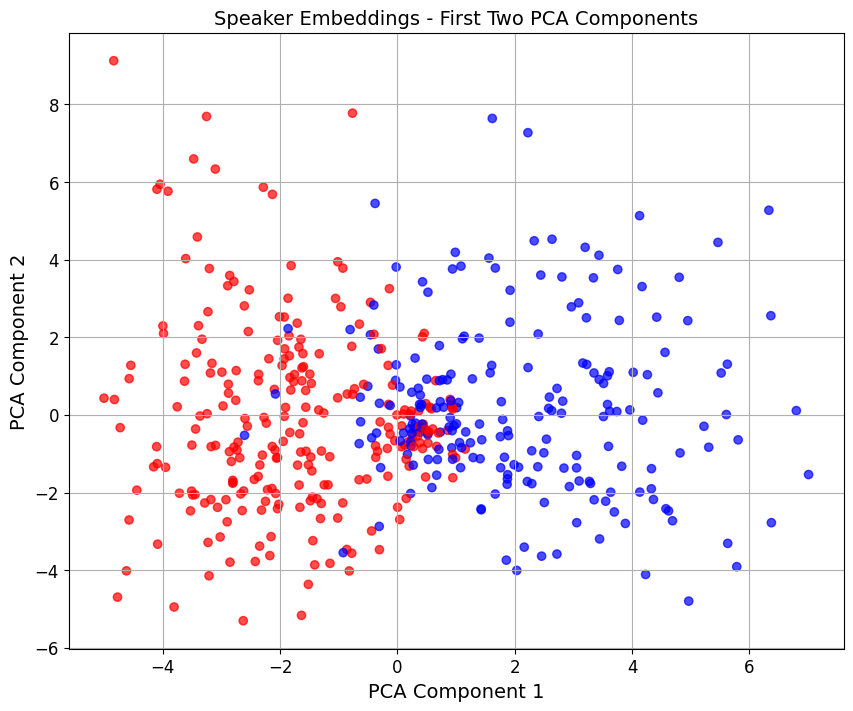

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Extract speaker embeddings in the order they appear in df_grouped
speaker_tags_ordered = [f"SPEAKER_{speaker}" for speaker in df["speaker"]]
speaker_embeddings = np.array([doc2vec_model.dv[tag] for tag in speaker_tags_ordered])

# Map party to colors
party_colors = {"R": "red", "D": "blue"}
colors = [party_colors[party] for party in df["party"]]

# Step 2: Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
speaker_embeddings_2d = pca.fit_transform(speaker_embeddings)

# Step 3: Plot the embeddings with colors based on party
plt.figure(figsize=(10, 8))
plt.scatter(speaker_embeddings_2d[:, 0], speaker_embeddings_2d[:, 1], c=colors, alpha=0.7)

# Annotate points with speaker names (optional)
#for i, speaker in enumerate(df["speaker"]):
#    plt.annotate(speaker, (speaker_embeddings_2d[i, 0], speaker_embeddings_2d[i, 1]), alpha=0.75)

plt.title("Speaker Embeddings - First Two PCA Components")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()


In [6]:
df['ideal_point'] = speaker_embeddings_2d[:,0]
mean_ideal_point = df

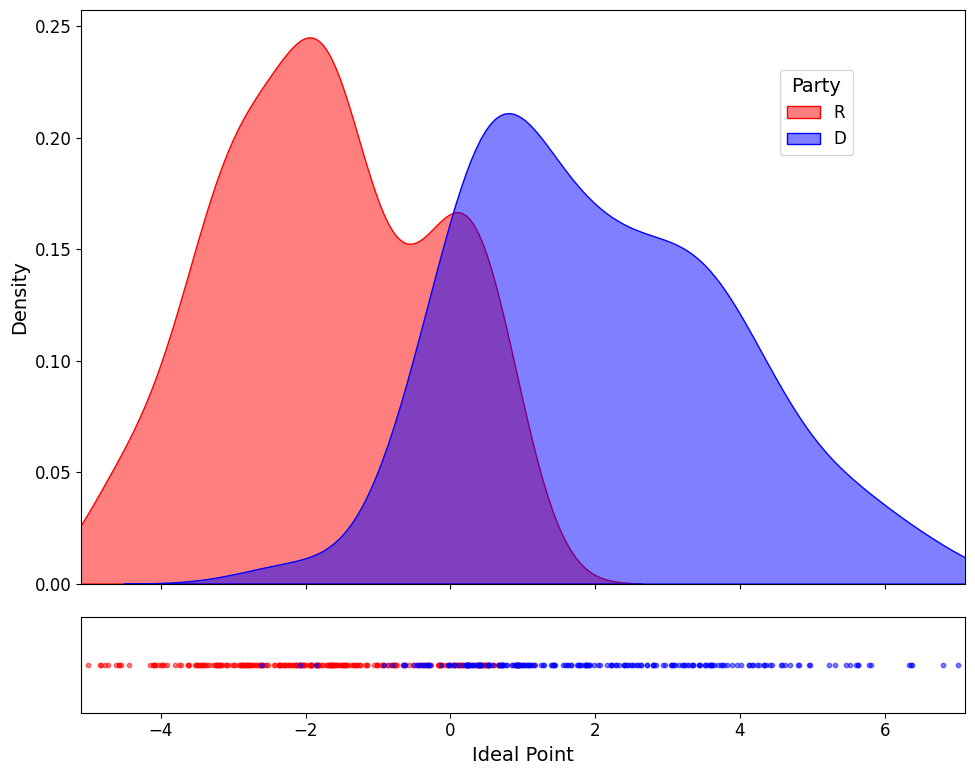

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for each party
colors = {'R': 'red', 'D': 'blue'}

# Set up the figure with two subplots: one for the density plot and one for the scatter plot
fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 0.5]}, sharex=True)

# Density plot (top subplot)
for party in mean_ideal_point['party'].unique():
    subset = mean_ideal_point[mean_ideal_point['party'] == party]
    sns.kdeplot(subset['ideal_point'], fill=True, color=colors[party], label=party, alpha=0.5, ax=axes[0])

# Customize density plot
axes[0].set_xlabel('')  # Remove redundant x-axis label
axes[0].set_ylabel('Density')

# Scatter plot (bottom subplot)
for party in mean_ideal_point['party'].unique():
    subset = mean_ideal_point[mean_ideal_point['party'] == party]
    axes[1].scatter(subset['ideal_point'], [1] * len(subset), color=colors[party], s=10, alpha=0.5)

# Customize scatter plot
axes[1].set_yticks([])  # Hide the y-axis ticks
axes[1].set_xlabel('Ideal Point')

# Set x-axis limits to be shared by both subplots
x_limits = [mean_ideal_point['ideal_point'].min()-0.1, mean_ideal_point['ideal_point'].max()+0.1]
axes[0].set_xlim(x_limits)
axes[1].set_xlim(x_limits)

# Add a unified legend in the top subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Party', loc=(0.8, 0.8))

# Adjust layout for a cleaner look
plt.tight_layout()
plt.savefig('congress_114_embeddings_pca.pdf')
plt.show()


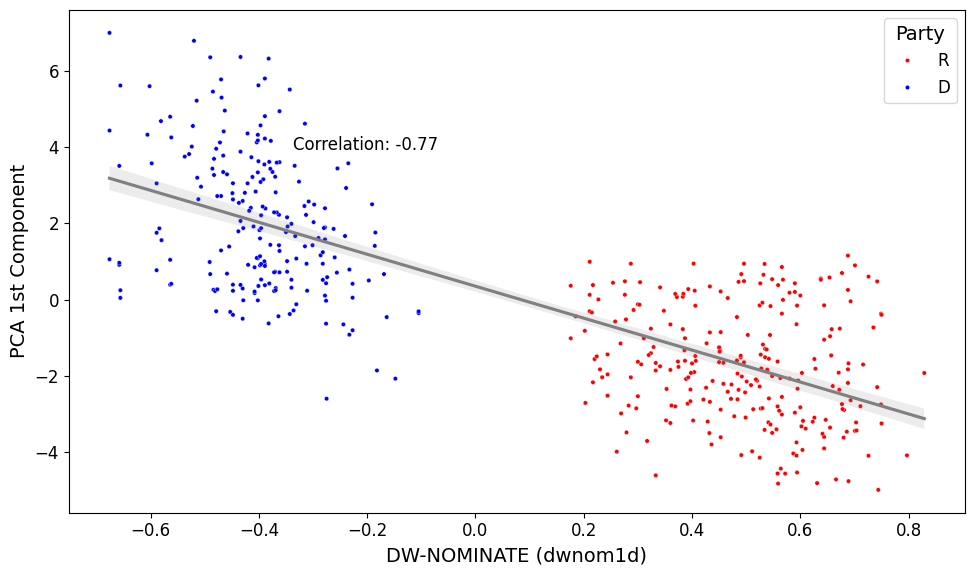

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Define colors for each party
colors = {'R': 'red', 'D': 'blue'}

# Calculate correlation coefficient
correlation, _ = pearsonr(mean_ideal_point['dwnom1d'], mean_ideal_point['ideal_point'])

# Scatter plot with linear fit
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mean_ideal_point, x='dwnom1d', y='ideal_point', hue='party', palette=colors, alpha=1, s=10)
sns.regplot(data=mean_ideal_point, x='dwnom1d', y='ideal_point', scatter=False, color='grey', line_kws={"label": "Linear Fit"})

# Display correlation coefficient
plt.text(0.25, 0.75, f'Correlation: {correlation:.2f}', ha='left', va='top', transform=plt.gca().transAxes, fontsize=12)

# Customize plot
plt.xlabel('DW-NOMINATE (dwnom1d)')
plt.ylabel('PCA 1st Component')
plt.legend(title='Party')
plt.tight_layout()
plt.savefig('congress_114_embeddings_pca_vs_dwnom1d.pdf')
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# Step 1: Extract speaker embeddings and colors
speaker_tags_ordered = [f"SPEAKER_{speaker}" for speaker in df["speaker"]]
speaker_embeddings = np.array([doc2vec_model.dv[tag] for tag in speaker_tags_ordered])

# Map party to colors
party_colors = {"R": "red", "D": "blue"}
colors = [party_colors[party] for party in df["party"]]

# Standardize embeddings
scaler = StandardScaler()
speaker_embeddings = scaler.fit_transform(speaker_embeddings)

# Convert to PyTorch tensor
speaker_embeddings_tensor = torch.tensor(speaker_embeddings, dtype=torch.float32)

# Step 2: Define the shallow autoencoder
class ShallowAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(ShallowAutoencoder, self).__init__()
        # Encoder: projects to 2D bottleneck layer
        self.encoder = nn.Linear(input_dim, 1)
        # Decoder: reconstructs back to original dimension
        self.decoder = nn.Linear(1, input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model, optimizer, and loss function
input_dim = speaker_embeddings.shape[1]
model = ShallowAutoencoder(input_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Step 3: Train the autoencoder
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    # Forward pass
    reconstructed = model(speaker_embeddings_tensor)
    loss = criterion(reconstructed, speaker_embeddings_tensor)
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

# Step 4: Extract the 2D embeddings from the bottleneck layer
with torch.no_grad():
    speaker_embeddings_2d = model.encoder(speaker_embeddings_tensor).numpy()

# Step 5: Plot the embeddings with colors based on party
#plt.figure(figsize=(10, 8))
#plt.scatter(speaker_embeddings_2d[:, 0], speaker_embeddings_2d[:, 1], c=colors, alpha=0.7)

# Annotate points with speaker names (optional)
#for i, speaker in enumerate(df["speaker"]):
#    plt.annotate(speaker, (speaker_embeddings_2d[i, 0], speaker_embeddings_2d[i, 1]), alpha=0.75)

#plt.title("Speaker Embeddings - First Two Autoencoder Components")
#plt.xlabel("Autoencoder Component 1")
#plt.ylabel("Autoencoder Component 2")
#plt.grid()
#plt.show()


/home/germain/Documents/neural_ideal_points/neural_ideal_point_models/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [0/500], Loss: 1.4131
Epoch [100/500], Loss: 0.9914
Epoch [200/500], Loss: 0.9775
Epoch [300/500], Loss: 0.9684
Epoch [400/500], Loss: 0.9642


In [10]:
df['ideal_point'] = speaker_embeddings_2d[:,0]
mean_ideal_point = df

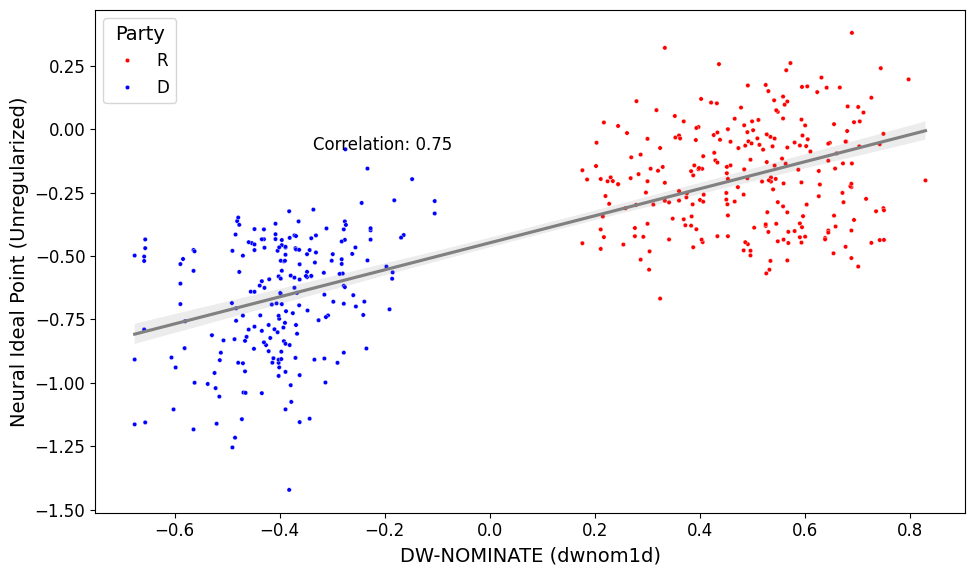

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Define colors for each party
colors = {'R': 'red', 'D': 'blue'}

# Calculate correlation coefficient
correlation, _ = pearsonr(mean_ideal_point['dwnom1d'], mean_ideal_point['ideal_point'])

# Scatter plot with linear fit
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mean_ideal_point, x='dwnom1d', y='ideal_point', hue='party', palette=colors, alpha=1, s=10)
sns.regplot(data=mean_ideal_point, x='dwnom1d', y='ideal_point', scatter=False, color='grey', line_kws={"label": "Linear Fit"})

# Display correlation coefficient
plt.text(0.25, 0.75, f'Correlation: {correlation:.2f}', ha='left', va='top', transform=plt.gca().transAxes, fontsize=12)

# Customize plot
plt.xlabel('DW-NOMINATE (dwnom1d)')
plt.ylabel('Neural Ideal Point (Unregularized)')
plt.legend(title='Party')
plt.tight_layout()
plt.savefig('congress_114_embeddings_ae_vs_dwnom1d.pdf')
plt.show()

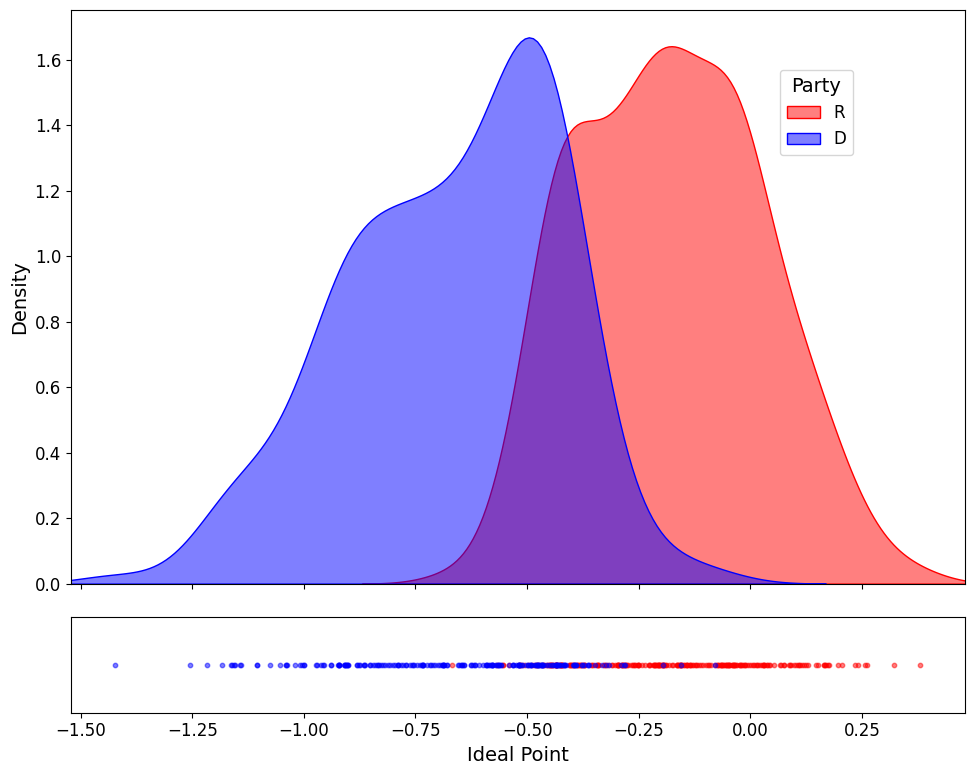

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for each party
colors = {'R': 'red', 'D': 'blue'}

# Set up the figure with two subplots: one for the density plot and one for the scatter plot
fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 0.5]}, sharex=True)

# Density plot (top subplot)
for party in mean_ideal_point['party'].unique():
    subset = mean_ideal_point[mean_ideal_point['party'] == party]
    sns.kdeplot(subset['ideal_point'], fill=True, color=colors[party], label=party, alpha=0.5, ax=axes[0])

# Customize density plot
axes[0].set_xlabel('')  # Remove redundant x-axis label
axes[0].set_ylabel('Density')

# Scatter plot (bottom subplot)
for party in mean_ideal_point['party'].unique():
    subset = mean_ideal_point[mean_ideal_point['party'] == party]
    axes[1].scatter(subset['ideal_point'], [1] * len(subset), color=colors[party], s=10, alpha=0.5)

# Customize scatter plot
axes[1].set_yticks([])  # Hide the y-axis ticks
axes[1].set_xlabel('Ideal Point')

# Set x-axis limits to be shared by both subplots
x_limits = [mean_ideal_point['ideal_point'].min()-0.1, mean_ideal_point['ideal_point'].max()+0.1]
axes[0].set_xlim(x_limits)
axes[1].set_xlim(x_limits)

# Add a unified legend in the top subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Party', loc=(0.8, 0.8))

# Adjust layout for a cleaner look
plt.tight_layout()
plt.savefig('congress_114_embeddings_ae.pdf')
plt.show()


In [13]:
import sys
sys.path.append('../IdealPointNN/')
from dataset import IdealPointNNDataset
from ideal_point_model import IdealPointNN

train_data = IdealPointNNDataset(
    df,
)
train_data.add_modality(
    df,
    modality = 'text'
)

train_data.data['text']['M_embeddings'] = speaker_embeddings

train_datasets = [train_data]

In [14]:
# Default parameters for the IdealPointNN model
encoder_args = {
    "encoder_input": "embeddings",
    "encoder_hidden_layers":[256],
    "encoder_non_linear_activation":"relu",
    "encoder_bias":False
}

decoder_args = {
    "text": {
        "decoder_hidden_layers":[],
        "decoder_non_linear_activation":"relu",
        "decoder_bias":False
    }
}


m = IdealPointNN(
    train_datasets,
    encoder_args=encoder_args,
    decoder_args=decoder_args,
    n_dims=1,
    update_prior=False,
    log_every_n_epochs=1,
    dropout=0,
    batch_size=115,
    w_prior=0.1,
    learning_rate=1e-2,
    print_every_n_batches=1000,
    print_every_n_epochs=50,
    num_epochs=300,
    patience=50
)

Epoch   1	Mean Loss: 1.1596377

Epoch   2	Mean Loss: 1.1269903

Epoch   3	Mean Loss: 1.1430390

Epoch   4	Mean Loss: 1.0774657

Epoch   5	Mean Loss: 1.0672499

Epoch   6	Mean Loss: 1.0617944

Epoch   7	Mean Loss: 1.0517227

Epoch   8	Mean Loss: 1.0533850

Epoch   9	Mean Loss: 1.0408194

Epoch  10	Mean Loss: 1.0399006

Epoch  11	Mean Loss: 1.0331892

Epoch  12	Mean Loss: 1.0283437

Epoch  13	Mean Loss: 1.0291641

Epoch  14	Mean Loss: 1.0220775

Epoch  15	Mean Loss: 1.0174211

Epoch  16	Mean Loss: 1.0107757

Epoch  17	Mean Loss: 1.0103535

Epoch  18	Mean Loss: 1.0042507

Epoch  19	Mean Loss: 0.9961556

Epoch  20	Mean Loss: 0.9907576

Epoch  21	Mean Loss: 0.9896584

Epoch  22	Mean Loss: 0.9819577

Epoch  23	Mean Loss: 0.9808477

Epoch  24	Mean Loss: 0.9808894

Epoch  25	Mean Loss: 0.9760206

Epoch  26	Mean Loss: 0.9746096

Epoch  27	Mean Loss: 0.9768318

Epoch  28	Mean Loss: 0.9732246

Epoch  29	Mean Loss: 0.9745861

Epoch  30	Mean Loss: 0.9708277

Epoch  31	Mean Loss: 0.9700167

Epoch  3

In [15]:
df['ideal_point'] = m.get_ideal_points(train_datasets)
mean_ideal_point = df

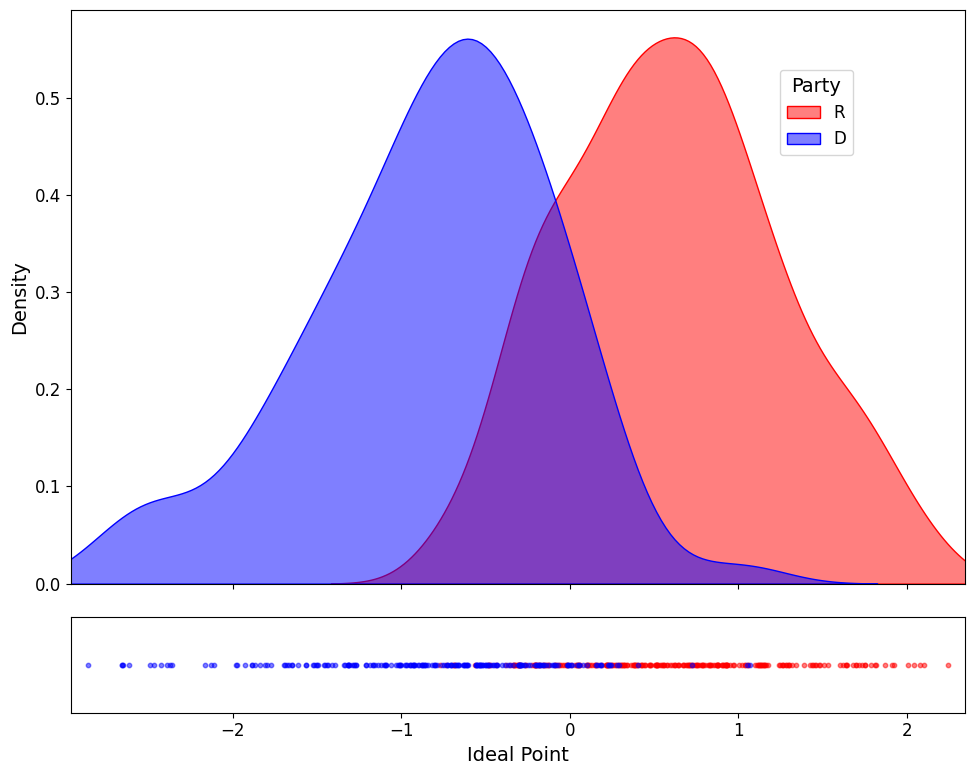

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for each party
colors = {'R': 'red', 'D': 'blue'}

# Set up the figure with two subplots: one for the density plot and one for the scatter plot
fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 0.5]}, sharex=True)

# Density plot (top subplot)
for party in mean_ideal_point['party'].unique():
    subset = mean_ideal_point[mean_ideal_point['party'] == party]
    sns.kdeplot(subset['ideal_point'], fill=True, color=colors[party], label=party, alpha=0.5, ax=axes[0])

# Customize density plot
axes[0].set_xlabel('')  # Remove redundant x-axis label
axes[0].set_ylabel('Density')

# Scatter plot (bottom subplot)
for party in mean_ideal_point['party'].unique():
    subset = mean_ideal_point[mean_ideal_point['party'] == party]
    axes[1].scatter(subset['ideal_point'], [1] * len(subset), color=colors[party], s=10, alpha=0.5)

# Customize scatter plot
axes[1].set_yticks([])  # Hide the y-axis ticks
axes[1].set_xlabel('Ideal Point')

# Set x-axis limits to be shared by both subplots
x_limits = [mean_ideal_point['ideal_point'].min()-0.1, mean_ideal_point['ideal_point'].max()+0.1]
axes[0].set_xlim(x_limits)
axes[1].set_xlim(x_limits)

# Add a unified legend in the top subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Party', loc=(0.8, 0.8))

# Adjust layout for a cleaner look
plt.tight_layout()
plt.savefig('congress_114_embeddings.pdf')
plt.show()


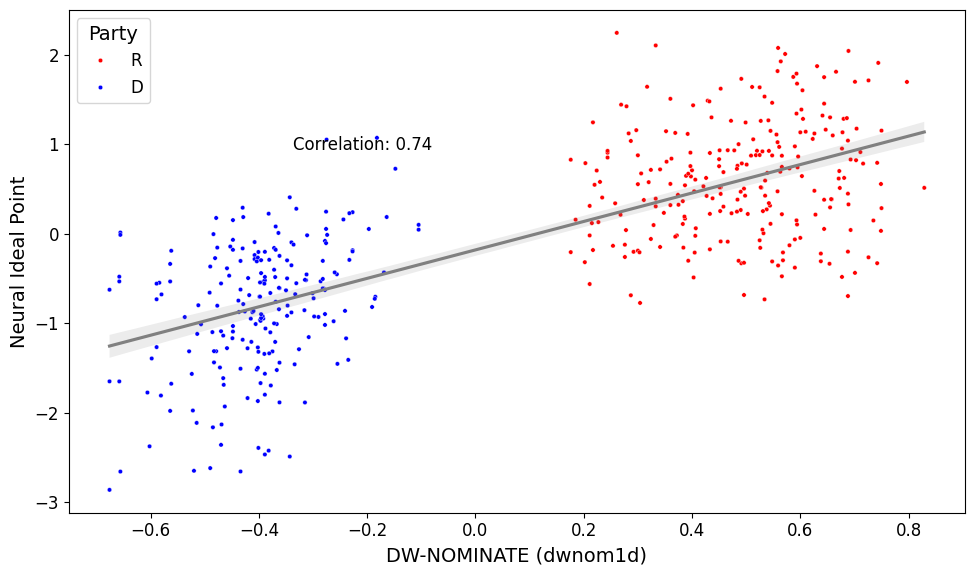

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Define colors for each party
colors = {'R': 'red', 'D': 'blue'}

# Calculate correlation coefficient
correlation, _ = pearsonr(mean_ideal_point['dwnom1d'], mean_ideal_point['ideal_point'])

# Scatter plot with linear fit
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mean_ideal_point, x='dwnom1d', y='ideal_point', hue='party', palette=colors, alpha=1, s=10)
sns.regplot(data=mean_ideal_point, x='dwnom1d', y='ideal_point', scatter=False, color='grey', line_kws={"label": "Linear Fit"})

# Display correlation coefficient
plt.text(0.25, 0.75, f'Correlation: {correlation:.2f}', ha='left', va='top', transform=plt.gca().transAxes, fontsize=12)

# Customize plot
plt.xlabel('DW-NOMINATE (dwnom1d)')
plt.ylabel('Neural Ideal Point')
plt.legend(title='Party')
plt.tight_layout()
plt.savefig('congress_114_embeddings_vs_dwnom1d.pdf')
plt.show()

In [18]:
word_vocab = doc2vec_model.wv.index_to_key  # List of words in vocabulary
"abortion" in word_vocab

True

In [19]:
partisan_words = ["mortgage", "school", "discrimination", "health", "dreamer", "taxpayer", "abortion", "alien", "homeland", "balanced_budget"]

for word in partisan_words:
    word_vector = torch.tensor(doc2vec_model.wv[word], dtype=torch.float32).to("cuda")
    print(m.Encoder(word_vector))

tensor([-0.3249], device='cuda:0', grad_fn=<SqueezeBackward4>)
tensor([-0.0980], device='cuda:0', grad_fn=<SqueezeBackward4>)
tensor([-0.8330], device='cuda:0', grad_fn=<SqueezeBackward4>)
tensor([-0.4543], device='cuda:0', grad_fn=<SqueezeBackward4>)
tensor([-0.0356], device='cuda:0', grad_fn=<SqueezeBackward4>)
tensor([0.1507], device='cuda:0', grad_fn=<SqueezeBackward4>)
tensor([-0.2571], device='cuda:0', grad_fn=<SqueezeBackward4>)
tensor([-0.2919], device='cuda:0', grad_fn=<SqueezeBackward4>)
tensor([-0.1846], device='cuda:0', grad_fn=<SqueezeBackward4>)
tensor([0.2486], device='cuda:0', grad_fn=<SqueezeBackward4>)


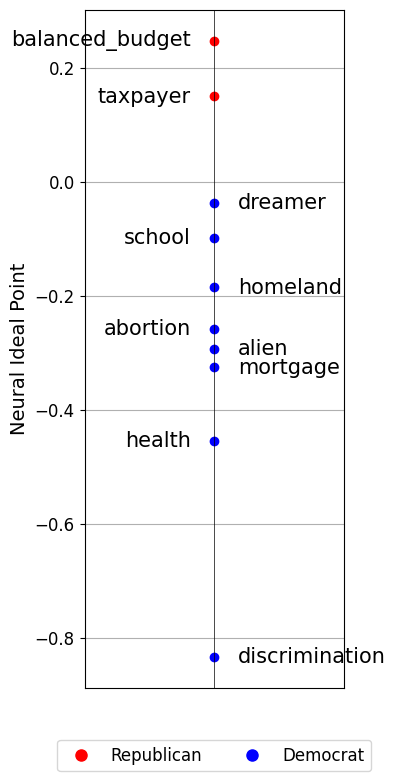

In [20]:
import torch
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# List of partisan words
partisan_words = ["mortgage", "school", "discrimination", "health", "dreamer", 
                  "taxpayer", "alien", "abortion", "homeland", "balanced_budget"]

# Dictionary to store the ideal points for each word
ideal_points = {}

# Extract and store the ideal points
for word in partisan_words:
    # Convert the word vector to a PyTorch tensor
    word_vector = torch.tensor(doc2vec_model.wv[word], dtype=torch.float32).to("cuda")
    # Get the ideal point from the encoder
    ideal_point = m.Encoder(word_vector)
    # Store the scalar ideal point
    ideal_points[word] = ideal_point.item()

# Plotting
plt.figure(figsize=(4, 8))
# Plot each word's ideal point on the y-axis (one-dimensional)
for i, (word, point) in enumerate(ideal_points.items()):
    color = 'red' if point > 0 else 'blue'
    plt.plot(0, point, 'o', color=color, label=word)
    
    # Alternate label positioning to prevent overlap
    ha = 'left' if i % 2 == 0 else 'right'
    plt.text(0.01 if ha == 'left' else -0.01, point, word, ha=ha, va='center')

# Add legend for red (Republicans) and blue (Democrats)
red_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Republican')
blue_marker = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=8, label='Democrat')
plt.legend(handles=[red_marker, blue_marker], loc="center", bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.axvline(0, color='black', linewidth=0.5)
plt.xticks([])
plt.ylabel("Neural Ideal Point")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('congress_114_embeddings_partisan_words.pdf')
plt.show()


In [21]:
import torch
import numpy as np

# Extract all words in the Doc2Vec vocabulary
word_vocab = doc2vec_model.wv.index_to_key

# Dictionary to store words and their corresponding ideal points
ideal_points = {}

# Process each word in the vocabulary
for word in word_vocab:
    # Convert the word vector to a PyTorch tensor
    word_vector = torch.tensor(doc2vec_model.wv[word], dtype=torch.float32).to("cuda")
    
    # Pass the tensor through the encoder to get the ideal point
    ideal_point = m.Encoder(word_vector)
    
    # Store the result in the dictionary
    ideal_points[word] = ideal_point.item()  # Convert to scalar

# Sort words by ideal point values
sorted_ideal_points = sorted(ideal_points.items(), key=lambda x: x[1])

# Get the top ten most negative and most positive ideal points
most_negative = sorted_ideal_points[:100]
most_positive = sorted_ideal_points[-100:]

# Output the results
print("Top 10 Most Negative Ideal Points:")
for word, point in most_negative:
    print(f"{word}: {point}")

print("\nTop 10 Most Positive Ideal Points:")
for word, point in most_positive:
    print(f"{word}: {point}")


Top 10 Most Negative Ideal Points:
workplace: -1.041530728340149
domestic_violence: -0.8952958583831787
voter: -0.8860170245170593
voting: -0.8464300632476807
discrimination: -0.8329996466636658
rider: -0.8102638721466064
shutdown: -0.8022128343582153
inequality: -0.7644208073616028
racism: -0.7639487981796265
gap: -0.756087601184845
defendant: -0.7498160600662231
prevention: -0.7451319694519043
racial: -0.7414780855178833
unfortunate: -0.731101393699646
minority: -0.7062051296234131
reproductive_health: -0.7043551206588745
gun_violence: -0.7039945125579834
disparity: -0.7027782201766968
likely: -0.699210524559021
unborn_baby: -0.6931873559951782
battle: -0.6652926206588745
discriminate: -0.6632111668586731
youth: -0.6607575416564941
repair: -0.6592456102371216
republican: -0.6573376655578613
violence: -0.6522736549377441
currency_manipulation: -0.628571629524231
white: -0.6263607740402222
neighborhood: -0.6135973334312439
universal: -0.6043654084205627
evening: -0.6014715433120728
rec